In [4]:
import numpy as np, pandas as pd
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing,AR,ARIMA,ARMA
from pmdarima.arima.utils import ndiffs
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,8), 'figure.dpi':150})

In [20]:
df = pd.read_csv('wwwusage.csv', names=['value'], header=0)
y = df.value

如果一个序列是白噪声(即独立同分布的随机数据),那么就无须再对其建立时间序列模型来预测, \
因为预测随机数是无意义的。因此在建立时间序列分析之前,需要先对其进行白噪声检验。 \
常用的白噪声检验方法是Ljung-Box检验(简称LB检验),其原假设和备择假设分别为 \
HO:延迟期数小于或等于m期的序列之间相互独立(序列是白噪声) \
H1:延迟期数小于或等于m期的序列之间有相关性(序列不是白噪声) \
Ljung-Box 检验可以使用 sm.stats.diagnostic.acorr_ljungbox()函数,对两个序列进行白噪声检验,程序如下: 

In [24]:
lags = [1,4,8,16,32]
LB = sm.stats.diagnostic.acorr_ljungbox(y,lags = lags,return_df = True)
print("序列X1的检验结果:\n",LB)

## 如果P值小于0.05，说明序列之间不独立，不是白噪声

序列X1的检验结果:
        lb_stat      lb_pvalue
1    94.988359   1.915081e-22
4   310.857230   4.926362e-66
8   431.171947   3.989963e-88
16  466.112357   4.655504e-89
32  751.709416  1.971571e-137


ARIMA模型的特征在于3个项：p，d，q \
p是AR项 \
q是MA项 \
d是使时间序列平稳所需的差分数 \
如果时间序列具有季节性模式，则需要添加季节性条件，该时间序列将变成SARIMA（“季节性ARIMA”的缩写）

因此，目的是识别p，d和q的值。

如何在ARIMA模型中找到差分阶数（d） \
进行差分的目的是使时间序列平稳。  \
但是您需要注意不要使序列过分差分。因为，超差分序列可能仍然是静止的，这反过来将影响模型参数。 \
那么如何确定正确的差分顺序呢？\
正确的差分顺序是获得近似平稳序列的最小差分，该序列围绕定义的平均值漫游，并且ACF曲线相当快地达到零。 \
如果自相关对于许多之后（10个或更多）为正，则该序列需要进一步求差。 \
在这种情况下，你不能真正确定两个差分阶数之间的差，然后选择在差分序列中给出最小标准偏差的阶次。 \
让我们来看一个例子。
首先，我将使用adfuller()statsmodels包中的Augmented Dickey Fuller测试（）检查该系列是否稳定。
为什么？ \
因为，仅当序列非平稳时才需要进行区分。否则，不需要差分，即d ＝ 0。 \
ADF检验的零假设是时间序列是非平稳的。因此，如果检验的p值小于显着性水平（0.05），则拒绝原假设，并推断时间序列确实是平稳的。 \
因此，在我们的情况下，如果P值> 0.05，我们将继续寻找差分的顺序。 

In [25]:
dfkpss = kpss(df.value.dropna())
dfoutput = pd.Series(dfkpss[0:3], index=["kpss_stat"," p-value"," usedlag"])
print("KPSS检验结果:\n",dfoutput)
## 接受序列平稳的原假设

X2 KPSS检验结果:
 kpss_stat     0.230579
 p-value      0.100000
 usedlag     12.000000
dtype: float64


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [35]:
dfkpss = kpss(df.value.diff(1).dropna())
dfoutput = pd.Series(dfkpss[0:3], index=["kpss_stat"," p-value"," usedlag"])
print("一阶差分 KPSS检验结果:\n",dfoutput)
## 接受序列平稳的原假设

一阶差分 KPSS检验结果:
 kpss_stat     0.116486
 p-value      0.100000
 usedlag     12.000000
dtype: float64


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [4]:
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


可见 P>0.05 序列不平稳，需要做差分
分别做一阶和二阶差分。可以看出二阶差分明显平稳多了

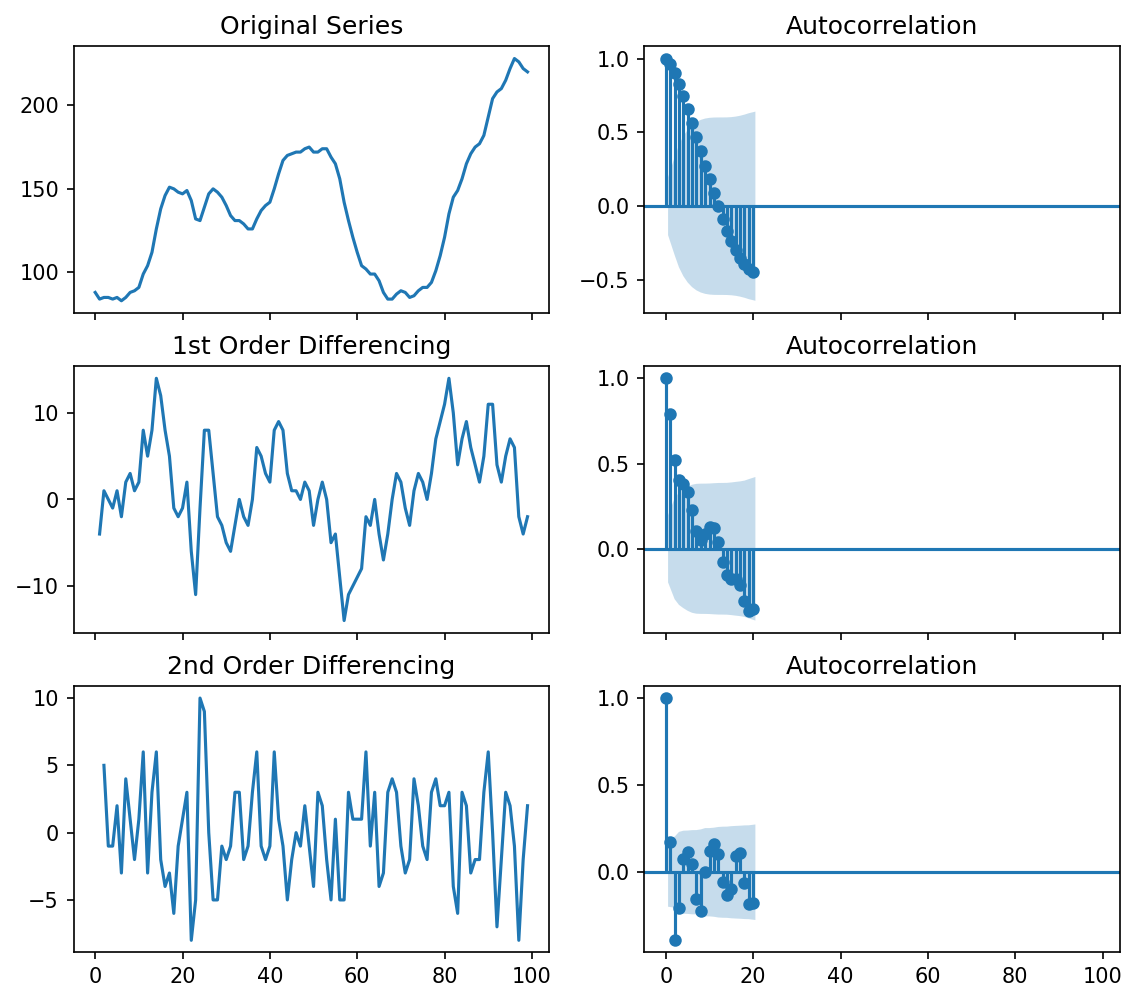

In [63]:
# 原始数据
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])
 
# 一阶差分
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])
 
# 二阶差分
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])
 
plt.show()

In [13]:
## Adf 检验
ndiffs(y, test='adf')  # 2

2

In [14]:
# KPSS test
ndiffs(y, test='kpss')  # 0

0

In [15]:
# PP test:
ndiffs(y, test='pp')  # 2

2

## AR阶数 
PACF滞后1非常重要，因为它远高于显着性线。滞后2事实也很重要，稍微超过了显着性限制（蓝色区域）。

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


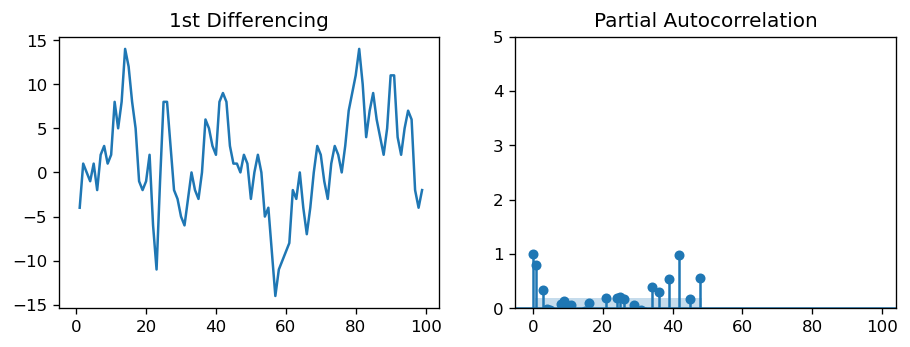

In [64]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1],lags=48)

plt.show()

## MA阶数

如何找到MA项的阶数(q) \
就像我们在PACF图上查看AR项的阶数一样，您也可以在ACF图上查看MA项的阶数。MA从技术上讲是滞后预测的误差。 \
ACF指示要删除平稳序列中的任何自相关需要多少个MA项。 \
让我们看一下差分序列的自相关图。 \
前几个滞后远高于界限。因此，让我们暂时将q固定为2。

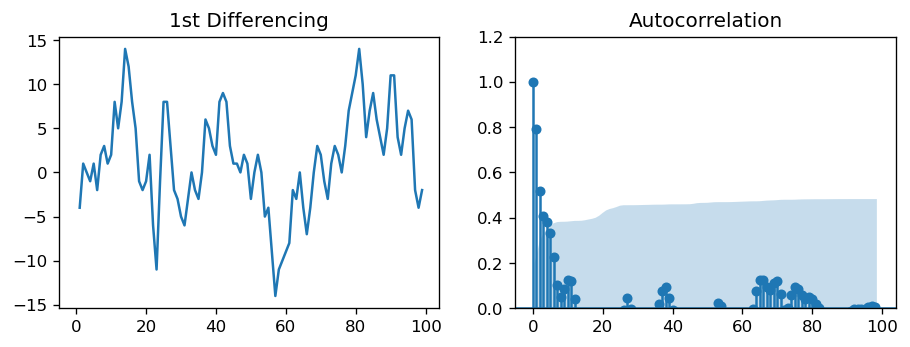

In [54]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1],lags=98)
plt.show()

In [106]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary()) 

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Tue, 16 Aug 2022   AIC                            516.253
Time:                        16:29:15   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

该模型摘要揭示了很多信息。中间的表是系数表，其中“ coef”下的值是相应项的权重。\
请注意，这里的MA2项的系数接近零 。理想情况下，各个X的值应小于0.05。\
因此，让我们在没有MA2项的情况下重建模型

In [107]:
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.150
Date:                Tue, 16 Aug 2022   AIC                            514.300
Time:                        16:29:17   BIC                            522.086
Sample:                             0   HQIC                           517.450
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6504      0.090      7.258      0.000       0.475       0.826
ma.L1          0.5256      0.088      5.994      0.000       0.354       0.697
sigma2         9.7934      1.405      6.970      0.0

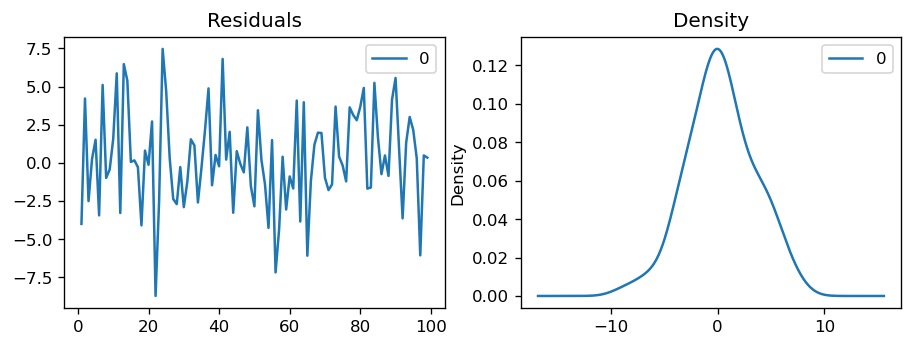

In [108]:
residuals = pd.DataFrame(model_fit.resid[1:])
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

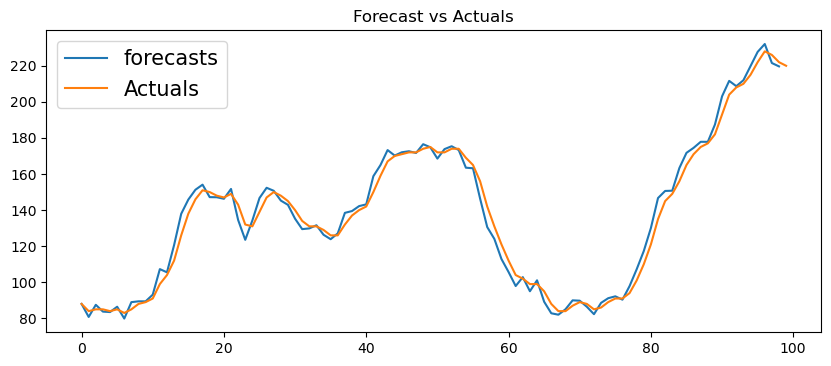

In [121]:
# 对比差异
plt.figure(figsize=(10,4), dpi=100)
plt.plot(model_fit.forecasts[0][1:], label='forecasts')
plt.plot(df.values, label='Actuals')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=15)
plt.show()

实际vs拟合 \
设置 dynamic=False样本内时，滞后值用于预测。 \
也就是说，模型被训练到上一个值进行下一个预测。 \
因此，我们似乎有一个不错的ARIMA模型。但是那是最好的吗？ \
目前不能这么说，因为我们还没有真正预测未来，而是将预测与实际绩效进行了比较。 \
因此， 现在需要的真正验证是超时交叉验证。 \
如何使用超时交叉验证手动找到最佳ARIMA模型 \
在“交叉验证”中，可以倒退几步，并预测将来的步伐。然后，您将预测值与实际值进行比较。 \
要进行超时的交叉验证，您需要创建训练和测试数据集，方法是将时间序列按大约75:25的比例或基于序列时间频率的合理比例分成两个连续的部分。 \
为什么不随机采样训练数据？ \
这是因为时间序列的顺序序列应完整无缺，以便用于预测

In [122]:
train

0      88
1      84
2      85
3      85
4      84
     ... 
80    121
81    135
82    145
83    149
84    156
Name: value, Length: 85, dtype: int64

In [201]:
model = ARIMA(train,order=(3, 2, 1))  
fitted = model.fit()  

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [202]:
# Forecast
fc = fitted.forecast(15, alpha=0.05) # 95% conf

In [203]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)

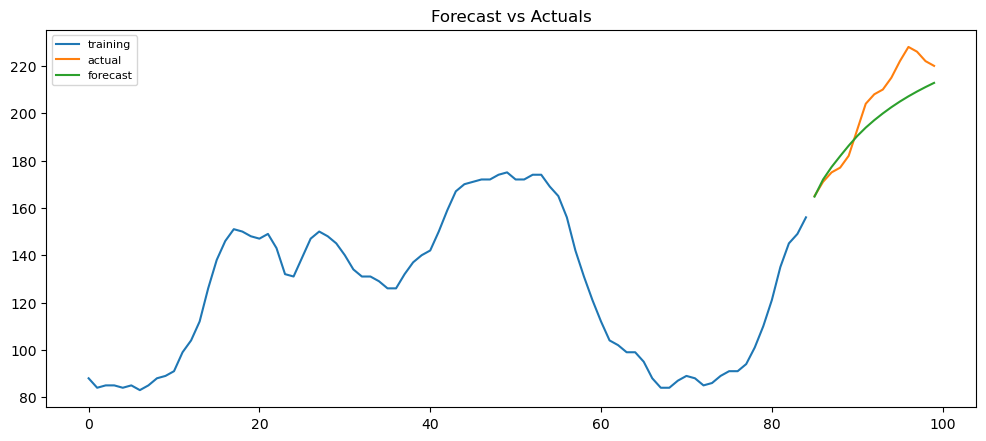

In [204]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [160]:
import pmdarima as pm

In [206]:
model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

## 如何解释ARIMA模型中的残差图

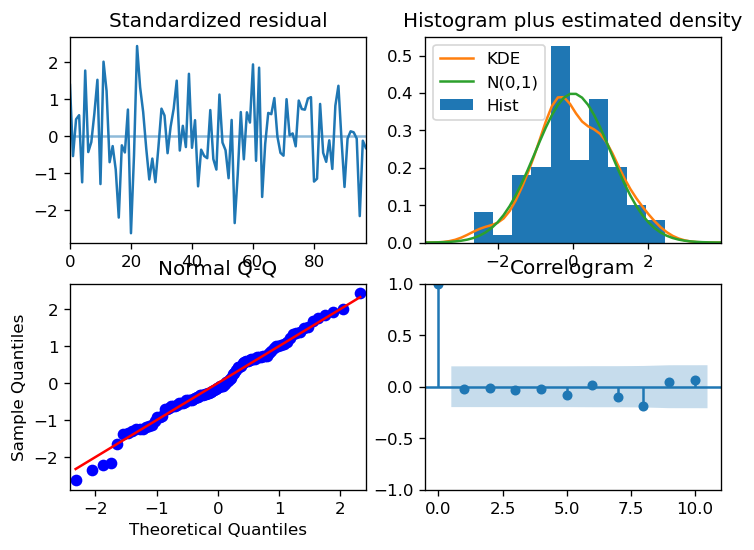

In [208]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

残差图
那么如何解释？

左上方：  残余误差似乎在零均值附近波动，并且具有均匀的方差。

右上方：  密度图接近均值为零的正态分布。

左下：  所有圆点应与红线完全一致。任何明显的偏差都意味着分布偏斜。

右下：  Correlogram（又名ACF）图显示残差误差不是自相关的。任何自相关都将暗示残差中存在某种模式，该模式未在模型中进行解释。因此，您将需要为模型寻找更多的X（预测变量）。

总体而言，模型很合适。让我们预测一下。

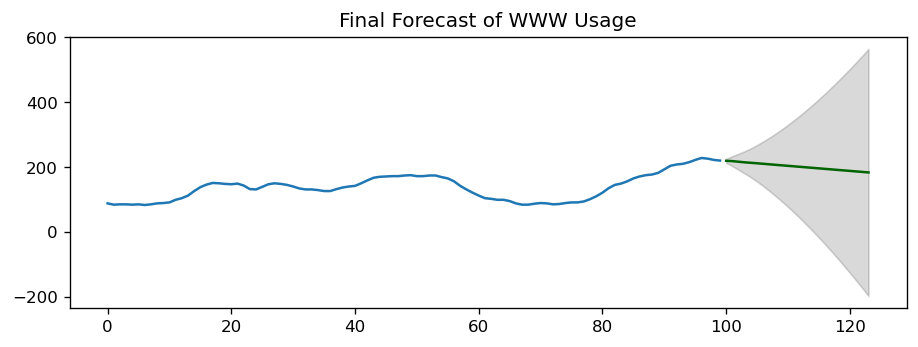

In [209]:
n_periods = 24
#返回置信区间 非常重要
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

In [211]:
data

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


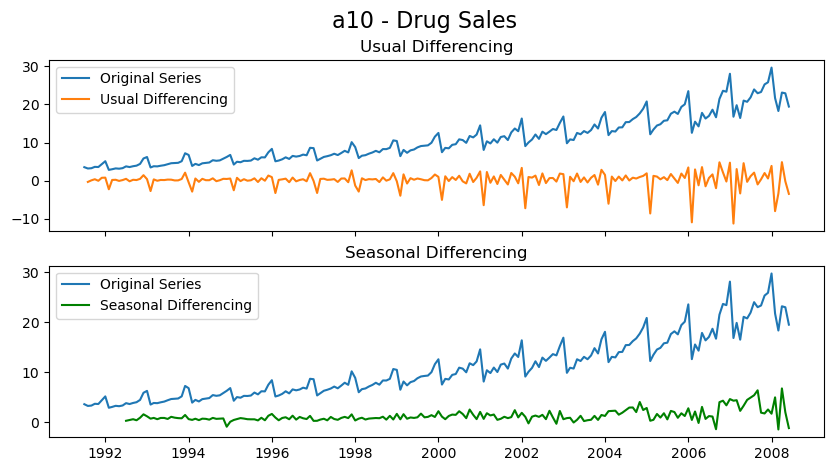

In [213]:
data = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)
# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [214]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(c, start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=0.69 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.17 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=2.30 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=0.69 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.951, Time=3.21 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.17 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=0.70 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.13 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

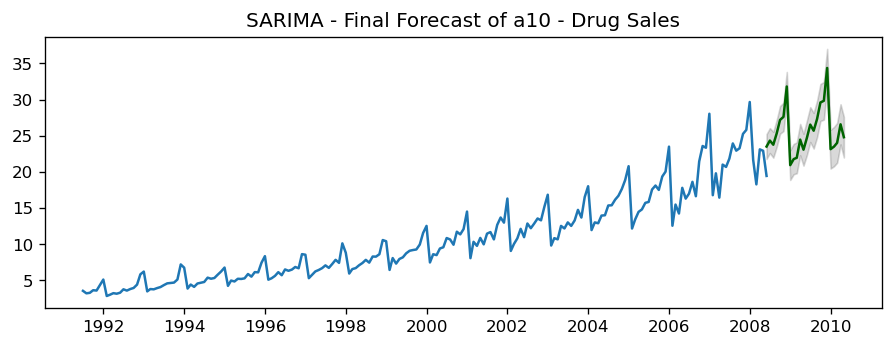

In [215]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()


通过季节性分解来选出季节因子作为外生变量加入模型

In [216]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

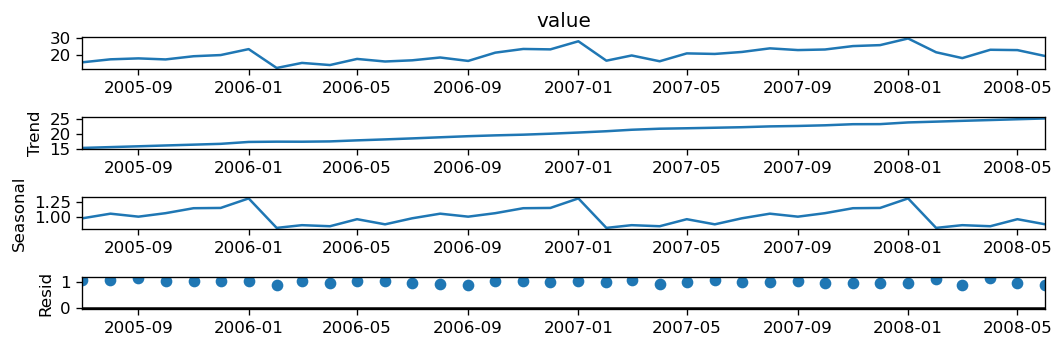

In [228]:
result_mul.plot()
plt.show()

实际上就是以一年为一个周期

In [222]:
df[0:14]

,value,month,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141
1991-12-01,4.306371,12,1.150750
1992-01-01,5.088335,1,1.316913
1992-02-01,2.814520,2,0.803279
1992-03-01,2.985811,3,0.850667


In [229]:
# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                        start_p=1, start_q=1,
                        test='adf',
                        max_p=3, max_q=3, m=12,
                        start_P=0, seasonal=True,
                        d=None, D=1, trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=536.818, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=626.061, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=598.068, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=613.475, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=759.274, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=561.407, Time=0.15 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=538.817, Time=2.78 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=545.106, Time=0.86 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=539.771, Time=3.92 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=596.467, Time=0.24 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=531.829, Time=0.85 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=557.198, Time=0.20 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

In [230]:
sxmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -253.982
Date:                            Tue, 16 Aug 2022   AIC                            525.963
Time:                                    17:56:07   BIC                            555.281
Sample:                                07-01-1991   HQIC                           537.837
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0051      0.009      0.558      0.577      -0.013       0.023
seasonal_index  9.489e-07   2744.500   3.46e-10      1.000   -5379.122    5379.122
ar.L1              0.9760      0.019     52.277      0.000       0.939       1.013
ma.L1             -0.8999      0.057    -15.800      0.000      -1.012      -0.788
ma.L2              0.2077      0.059      3.547      0.000       0.093       0.322
ar.S.L12           0.8431      0.165      5.116      0.000       0.520       1.166
ma.S.L12          -1.5719      0.185     -8.495      0.000      -1.935      -1.209
ma.S.L24           0.7495      0.113      6.653      0.000       0.529       0.970
sigma2             0.7544      0.065     11.637      0.000       0.627       0.881
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               141.95
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):              14.65   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

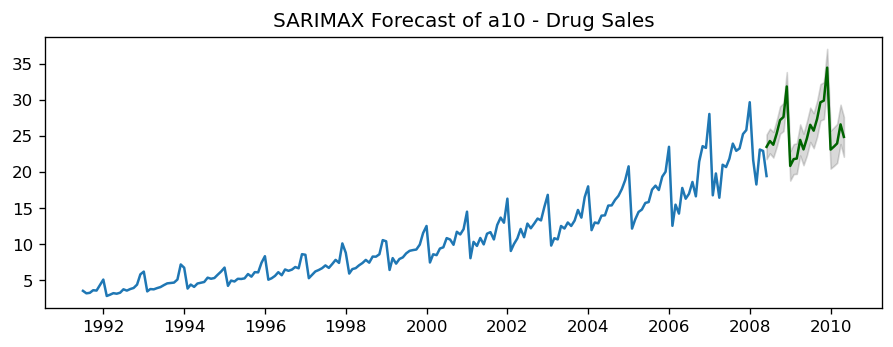

In [244]:
# 因此，我们拥有带有外生项的模型。但是该系数对于来说很小 x1，因此该变量的贡献可以忽略不计。让我们继续预测吧。
# 我们已有效地将模型中最近3年的最新季节性影响强加给模型。
# 好吧，让我们预测下一个24个月。为此，你需要接下来24个月的季节性指数值。
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.seasonal, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

In [249]:
model1 = ExponentialSmoothing(data.value,
                              seasonal_periods=12, # 周期性为12  
                              trend="add", seasonal="add").fit()
fitted_series = model1.forecast(n_periods)

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


使用三次指数平滑作为对比，效果似乎差不多

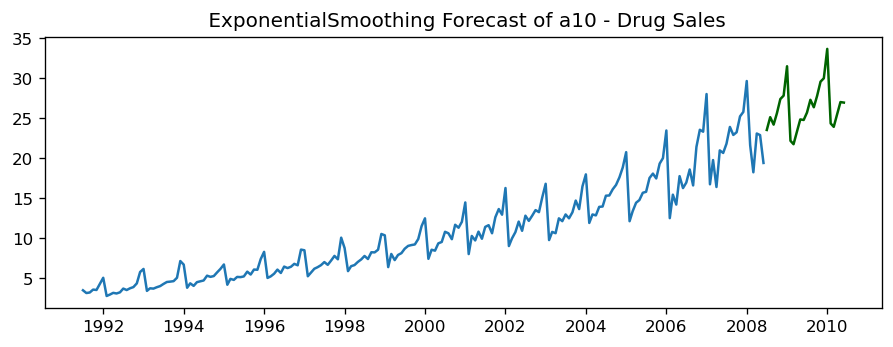

In [251]:
plt.title(" ExponentialSmoothing Forecast of a10 - Drug Sales")
plt.plot(data.value)
plt.plot(fitted_series, color='darkgreen')

In [1]:
from prophet import Prophet

In [5]:
df = pd.read_csv("AirPassengers.csv")
df.columns = ["ds","y"]
## 定义时间数据的数据类型
df["ds"] = pd.to_datetime(df["ds"])
print(df.head())

          ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121


In [6]:
## 数据切分为训练集和测试集
train = df[0:120]
test = df[120:]
 
## 构建模型
model = Prophet(growth = "linear",   # 线性增长趋势
                yearly_seasonality = True, # 年周期的趋势
                weekly_seasonality = False,# 以周为周期的趋势
                daily_seasonality = False,  # 以天为周期的趋势
                seasonality_mode = "multiplicative", # 季节周期性模式
                seasonality_prior_scale = 12, # 季节周期性长度
               )
model.fit(train)


18:24:22 - cmdstanpy - INFO - Chain [1] start processing
18:24:22 - cmdstanpy - INFO - Chain [1] done processing
18:24:22 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
18:24:22 - cmdstanpy - INFO - Chain [1] start processing
18:24:22 - cmdstanpy - INFO - Chain [1] done processing
18:24:22 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization: 